In [12]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import pearsonr

In [13]:
# Load data
df = pd.read_csv('https://raw.githubusercontent.com/huy164/datasets/master/walmart_stock_price.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)


In [14]:
# Split data into train, test, validate sets
train_size = int(len(df)*0.7)
test_size = int(len(df)*0.2)
validate_size = len(df) - train_size - test_size

train = df.iloc[:train_size]
test = df.iloc[train_size:train_size+test_size]
validate = df.iloc[train_size+test_size:]

In [16]:
# Apply SSA to train dataset
X = train['Close'].to_numpy()
window_size = 30
X_windowed = np.array([X[i:i+window_size] for i in range(len(X)-window_size+1)])

U, s, Vt = np.linalg.svd(X_windowed, full_matrices=False)
num_eigenvalues = 10
S = np.zeros((num_eigenvalues, num_eigenvalues))
S[:num_eigenvalues, :num_eigenvalues] = np.diag(s[:num_eigenvalues])
U_tilde = U[:, :num_eigenvalues]
X_tilde = U_tilde @ S

X_train = X_tilde[:, :-1]
y_train = X_tilde[:, -1]

In [17]:
# Fit linear regression model to train dataset
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [20]:
# Apply SSA to test dataset
X_test = np.array([test['Close'][i:i+window_size].to_numpy() for i in range(test_size-window_size+1)])[:, :num_eigenvalues-1]
y_test = test['Close'].to_numpy()[window_size-1:]
y_pred = model.predict(X_test[:, :num_eigenvalues-1])

In [21]:
# Combine test and validate datasets for future prediction
future_data = np.concatenate((test['Close'].to_numpy(), validate['Close'].to_numpy()))

In [30]:
# Apply SSA to future data
X_future = future_data
X_future_windowed = np.array([X_future[i:i+window_size] for i in range(len(X_future)-window_size+1)])

U_future, s_future, Vt_future = np.linalg.svd(X_future_windowed, full_matrices=False)
num_eigenvalues_future = min(num_eigenvalues, len(s_future))
S_future = np.zeros((num_eigenvalues_future, num_eigenvalues_future))
S_future[:num_eigenvalues_future, :num_eigenvalues_future] = np.diag(s_future[:num_eigenvalues_future])
U_future_tilde = U_future[:, :num_eigenvalues_future]
Vt_future_tilde = Vt_future[:num_eigenvalues_future, :]
X_tilde_future = U_future_tilde @ S_future @ Vt_future_tilde

X_future_pred = X_tilde_future[:, :num_eigenvalues-1] # Cắt bớt số lượng eigenvalues cho phù hợp với kích thước của mô hình LinearRegression
y_future_pred = model.predict(X_future_pred)

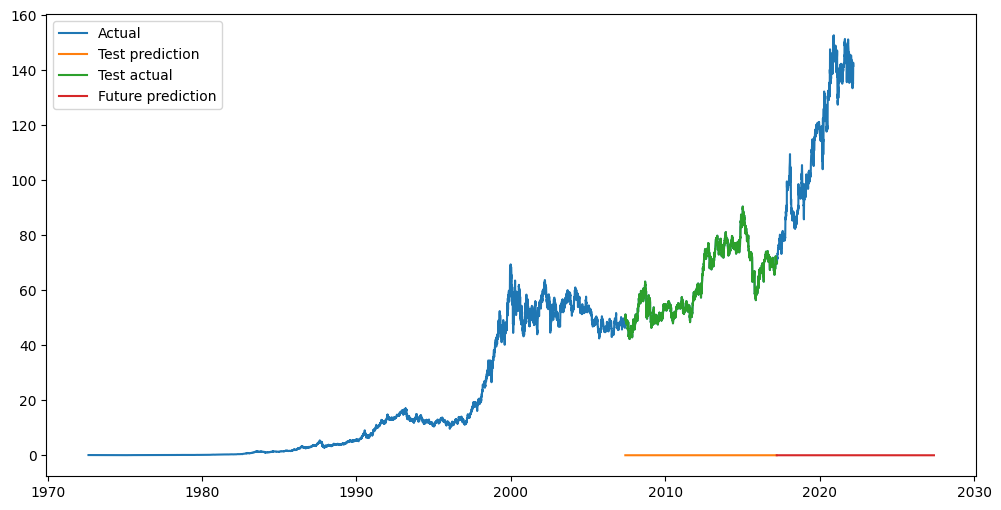

In [32]:
# Plot results
plt.figure(figsize=(12, 6))

# Plot actual data
plt.plot(df.index, df['Close'], label='Actual')

# Plot test data and predictions
test_end_date = test.index[-1]
test_dates = test.index[window_size-1:]
plt.plot(test_dates, y_pred, label='Test prediction')
plt.plot(test_dates, test['Close'][window_size-1:], label='Test actual')

# Plot future predictions
future_dates = pd.date_range(start=test_end_date+timedelta(days=1), periods=len(y_future_pred), freq='D')
plt.plot(future_dates, y_future_pred[:len(future_dates)], label='Future prediction')

plt.legend()
plt.show()

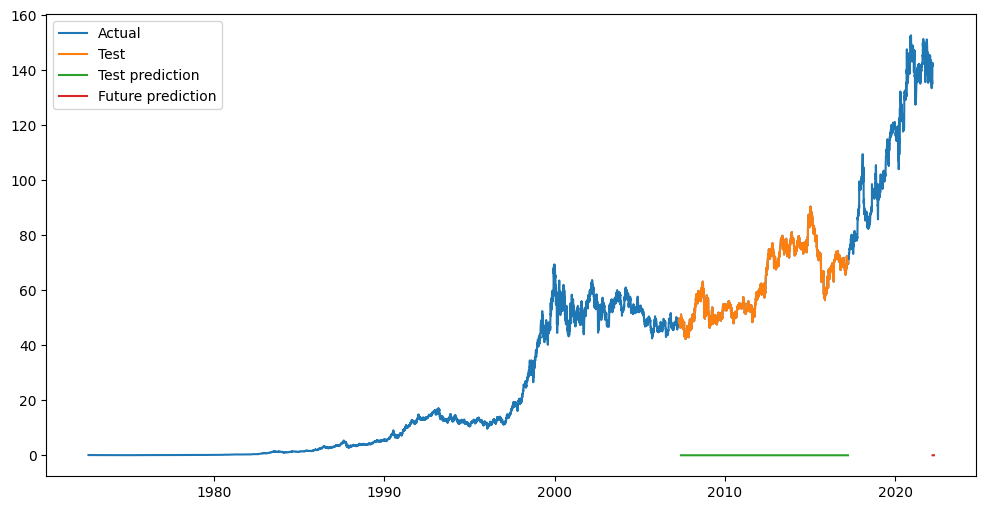

In [34]:
future_dates = pd.date_range(start=df.index[-1], periods=31, freq='D')[1:]
y_future_pred_cut = y_future_pred[:len(future_dates)]
future_pred = pd.Series(y_future_pred_cut, index=future_dates)

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Actual')
plt.plot(test.index, test['Close'], label='Test')
plt.plot(test.index[window_size-1:], y_pred, label='Test prediction')
plt.plot(future_pred.index, future_pred, label='Future prediction')
plt.legend()
plt.show()